# BAL Spectra analysis
In this notebook, Spectra factors are compared between RPRA and healthy subjects as follows:

1. For each cell type, subjects are filtered using the same criteria as during DGE analysis.
2. For each subject and each cell type, the mean cell score for each factor is computed. We refer to this score as the subject score.
2. For each cell type, a Wilcoxon rank sum test is used to test whether the RPRA subject scores are stochastically greater than the healthy subject scores.

In [1]:
import math
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import scipy
import pickle
import csv
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
from itertools import groupby
import matplotlib.patches as patches

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
v = "GEO_v2"
adata = sc.read_h5ad(f"{data_dir}/01BAL/01integrated_BAL_{v}/01integrated_BAL_{v}.h5ad")

In [4]:
# Remove epithelial cells and SARS-CoV-2
adata = adata[~adata.obs.cell_type.isin(["Epithelial cells", "SARS-CoV-2"])].copy()
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()

In [5]:
cell_types = adata.obs.cell_type.cat.categories.to_list()

## Compute cell and subject scores

In [6]:
def get_factor_celltypes(adata, obs_key):
    cell_scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'])
    cell_scores_df['celltype'] = list(adata.obs[obs_key])
    
    global_factors_series = (cell_scores_df.groupby('celltype').mean() != 0).all()
    global_factors = [factor for factor in global_factors_series.index if global_factors_series[factor]]
    specific_cell_scores = (cell_scores_df.groupby('celltype').mean()).T[~global_factors_series].T
    specific_factors = {}
    
    for i in set(cell_scores_df['celltype']):
        specific_factors[i] = [factor for factor in specific_cell_scores.loc[i].index if
                               specific_cell_scores.loc[i, factor]]
    
    factors_inv = {}
    for i,v in specific_factors.items():
        for factor in v:
            factors_inv[factor] = i
    
    for factor in global_factors:
        factors_inv[factor] = 'global'
            
    return factors_inv

In [7]:
factor_celltypes = get_factor_celltypes(adata, 'cell_type_spectra')

# Obtain gene weights
gene_weights = pd.DataFrame(
    adata.uns['SPECTRA_factors'], 
    index = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])],
    columns = adata.var[adata.var['spectra_vocab']].index
).T

# Obtain cell scores
cell_scores = pd.DataFrame(
    adata.obsm['SPECTRA_cell_scores'], 
    index = adata.obs_names,
    columns = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])]
)

# Map pathway names to factor names
with open(f"{data_dir}/01BAL/spectra/orig_factor_names_map.pkl", 'rb') as f:
    orig_factor_names_map = pickle.load(f)
factor_names_map = {k: ''.join(v.split('_')[:2]) for k, v in orig_factor_names_map.items()}
gene_weights.columns = pd.Index([factor_names_map[x] for x in gene_weights.columns])
cell_scores.columns = pd.Index([factor_names_map[x] for x in cell_scores.columns])

In [8]:
# Write top 100 genes per factor
gene_dict = {}
weight_dict = {}
ngene = 100
for pw in gene_weights.columns:
    top_genes = gene_weights[pw].sort_values(ascending = False)[0:ngene]
    gene_dict[pw] = top_genes.index.tolist()
    weight_dict[pw] = top_genes
    
with open(f"{data_dir}/01BAL/spectra/top_genes.csv", 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(["Pathway", "Gene", "Weight"])
    for k in gene_dict.keys():
        pairs = list(zip(gene_dict[k], weight_dict[k]))
        for g,w in pairs:
            writer.writerow([k, g, w])

In [9]:
# Add metadata to cell scores
cell_scores["Status"] = adata.obs.is_RPRA.astype(str).map({'True': 'RPRA', 'False': 'Healthy'})
cell_scores["Study_ID"] = adata.obs.Study_ID.astype(str)
cell_scores["cell_type"] = adata.obs.cell_type.astype(str)

In [10]:
# Compute subject scores as mean cell score
subject_scores = cell_scores.groupby(['Study_ID', 'cell_type', 'Status']).agg(['mean', 'count']).reset_index()

# Record number of cells for each subject/cell type combination
count_cols = subject_scores.columns.get_level_values(1) == 'count'
counts = subject_scores.iloc[:, count_cols].iloc[:, [0]].droplevel(1, axis = 1)
subject_scores = subject_scores.iloc[:, ~count_cols].droplevel(1, axis = 1)
subject_scores.insert(3, 'n_cell', counts)

## Filtering
We prefilter factors which have zero expression across all subjects.

In [11]:
MIN_CELLS = 40
CUTOFF = 0.01
def get_ct_score(cell_type, sfilt):
    ct_scores = subject_scores.loc[subject_scores.cell_type == cell_type].copy()
    if sfilt:
        total_cells = np.sum(adata.obs.cell_type == cell_type)
        cutoff = math.floor(CUTOFF * total_cells)
        ct_scores = ct_scores[ct_scores.n_cell > max(MIN_CELLS, cutoff)]
    ct_scores = ct_scores.loc[:, ct_scores.sum(axis = 0) != 0]
    return ct_scores

## Differential factor expression
The question we ask here is: in a given cell type, which factors are differentially expressed between RPRA and healthy subjects? We consider cell types separately, and therefore correct p-values for each cell type separately. This is in line with how we performed DGE analysis.

In [12]:
df_all = pd.DataFrame(columns = ['cell_type', 'Pathway', 'SNR', 'Upregulated', 'pval', 'padj'])
for ct in cell_types:
    df = pd.DataFrame(columns = ['cell_type', 'Pathway', 'SNR', 'Upregulated', 'pval'])
    
    # Require at least three subjects per condition for testing
    ct_scores = get_ct_score(ct, sfilt = True)
    if (ct_scores.shape[0] > 0) and ((ct_scores.Status.value_counts() >= 3).sum() == 2):
        rpra_scores = ct_scores.loc[ct_scores.Status == 'RPRA']
        ctrl_scores = ct_scores.loc[ct_scores.Status == 'Healthy']
        for pw in ct_scores.columns[4:]:
            pval = scipy.stats.mannwhitneyu(ctrl_scores[pw], rpra_scores[pw]).pvalue
            upreg = 'RPRA' if np.median(rpra_scores[pw]) > np.median(ctrl_scores[pw]) else 'Healthy'

            signal = (np.mean(rpra_scores[pw]) - np.mean(ctrl_scores[pw]))
            noise = (np.std(rpra_scores[pw]) + np.std(ctrl_scores[pw]))
            snr = signal / noise

            df = pd.concat([df, pd.DataFrame([[ct, pw, snr, upreg, pval]], columns = df.columns)],
                           ignore_index = True)
        _, df['padj'] = fdrcorrection(df.pval, alpha = 0.05, method = 'p')
    else:
        ct_scores = get_ct_score(ct, sfilt = False)
        rpra_scores = ct_scores.loc[ct_scores.Status == 'RPRA']
        ctrl_scores = ct_scores.loc[ct_scores.Status == 'Healthy']
        
        for pw in ct_scores.columns[4:]:
            signal = (np.mean(rpra_scores[pw]) - np.mean(ctrl_scores[pw]))
            if signal > 0:
                noise = (np.std(rpra_scores[pw]) + np.std(ctrl_scores[pw]))
                snr = signal / noise
            else:
                snr = 0
            df = pd.concat([df, pd.DataFrame([[ct, pw, snr, None, None]], columns = df.columns)],
                           ignore_index = True)
        df['padj'] = None
    
    df_all = pd.concat([df_all, df])
    
df_all = df_all.reset_index(drop = True)

In [13]:
df_all_filt = df_all[~np.isnan(df_all.pval)].copy()
df_all_filt = df_all_filt[df_all_filt.padj <= 0.05].reset_index(drop = True)
df_all_filt

,cell_type,Pathway,SNR,Upregulated,pval,padj
0,TRAM-5,F0,0.787233,RPRA,0.001092,0.016375
1,TRAM-5,F10,0.647887,RPRA,0.003124,0.028120
2,TRAM-5,F19,0.943505,RPRA,0.001092,0.016375
3,TRAM-5,F42,0.653608,RPRA,0.000151,0.006776
4,TRAM-5,F43,-1.026948,Healthy,0.003124,0.028120
5,MoAM-3,F19,1.02667,RPRA,0.001581,0.023715
6,MoAM-3,F42,0.994941,RPRA,0.001581,0.023715
7,MoAM-3,F43,-1.170399,Healthy,0.000903,0.023715
8,Proliferating macrophages,F0,1.181869,RPRA,0.000188,0.008470
9,Proliferating macrophages,F12,0.986398,RPRA,0.002823,0.042349


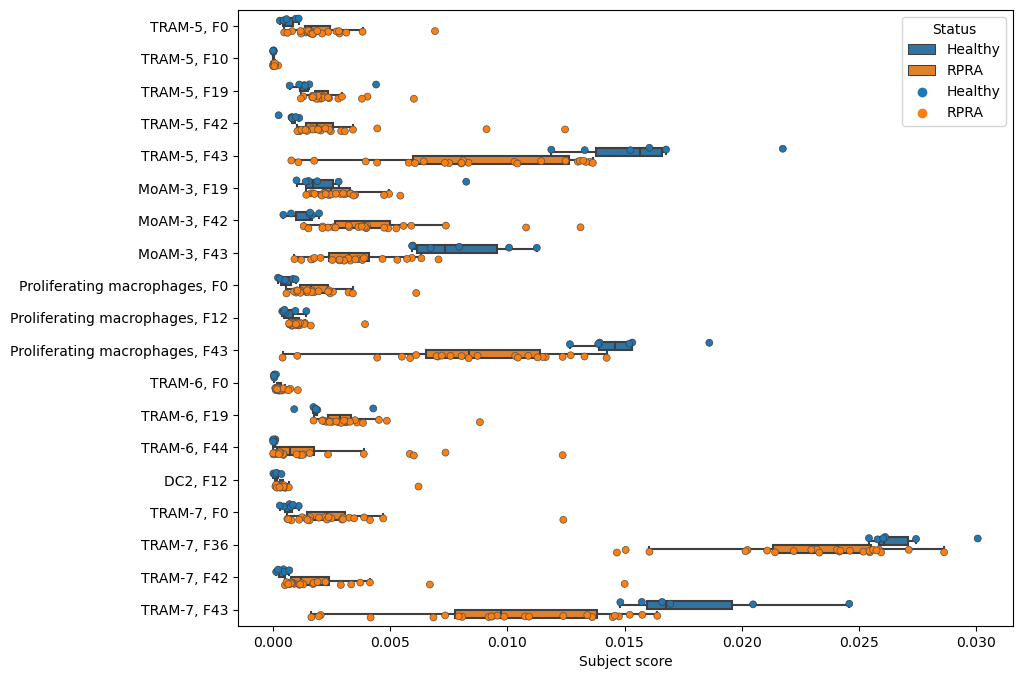

In [14]:
score_melt = subject_scores.melt(id_vars = ['cell_type', 'Status'], var_name = 'Pathway', value_name = 'Score')
sig_scores = pd.DataFrame(columns = ['cell_type', 'Status', 'Pathway', 'Score'])
for i in range(df_all_filt.shape[0]):
    pw = df_all_filt.iloc[i].Pathway
    ct = df_all_filt.iloc[i].cell_type
    sig_df = score_melt[(score_melt['cell_type'] == ct) & (score_melt['Pathway'] == pw)]
    sig_scores = pd.concat([sig_scores, sig_df])
sig_scores = sig_scores.reset_index(drop = True)
sig_scores['cell_type_Pathway'] = sig_scores.cell_type + ', ' + sig_scores.Pathway

plt.figure(figsize = (10, 8))
sns.boxplot(data = sig_scores, x = 'Score', y = 'cell_type_Pathway', hue = 'Status', fliersize = 0,
            width = 0.5)
sns.stripplot(data = sig_scores, x = 'Score', y = 'cell_type_Pathway', hue = 'Status',
              jitter = True, dodge = True, edgecolor = 'gray', linewidth = 0.5)
plt.xlabel("Subject score")
plt.ylabel(None);

## Heatmap comparing RPRA vs HV

In [15]:
mat = df_all.drop(columns = ['Upregulated', 'pval', 'padj'])
mat = mat.pivot(index = 'cell_type', columns = 'Pathway', values = 'SNR')
mat = mat.loc[:, mat.abs().sum(axis = 0) != 0].T
mat = mat.fillna(0)

In [16]:
annot = pd.DataFrame([[''] * mat.shape[1] for _ in range(mat.shape[0])])
for i in range(df_all_filt.shape[0]):
    row = mat.index.get_loc(df_all_filt.iloc[i].Pathway)
    col = mat.columns.get_loc(df_all_filt.iloc[i].cell_type)
    annot.iloc[row, col] = '*'

In [17]:
mat.index = pd.Index([''.join(x.split('_')[0:2]) for x in mat.index])

In [18]:
g = sns.clustermap(mat, z_score = None, xticklabels = 1, yticklabels = 1, cmap = 'coolwarm',
                   figsize = (10, 18), cbar_pos = (1, 0.41, 0.04, 0.18), dendrogram_ratio = 0.1,
                   center = 0)
for text in g.ax_heatmap.texts:
    text.set_visible(False)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        # Reordered row and column indices
        rrow = g.dendrogram_row.reordered_ind[i]
        rcol = g.dendrogram_col.reordered_ind[j]
        g.ax_heatmap.text(j + 0.45, i + 0.6, annot.iloc[rrow, rcol], ha = 'center', va = 'center')

g.ax_heatmap.tick_params(axis = 'x', labelsize = 10)
g.ax_heatmap.tick_params(axis = 'y', labelsize = 10)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)
g.ax_heatmap.text(31.75, 28.75, "Up in RPRA", fontsize = 10)
g.ax_heatmap.text(31.75, 46.75, "Down in RPRA", fontsize = 10)

plt.savefig(f"{data_dir}/figures/fig_4/fig_4c.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Barplots of gene weights

In [19]:
ngene = 25
pathways = np.sort(list(pd.unique(df_all_filt.Pathway)) + ['F25', 'F30', 'F35'])

nr = 3
nc = 4
fig, axs = plt.subplots(nr, nc, figsize = (14, 16))
for i in range(nr):
    for j in range(nc):
        ix = nc * i + j
        if ix < len(pathways):
            p = pathways[ix]
            w = pd.DataFrame(gene_weights[p]).sort_values(p, ascending = False)[0:ngene][::-1]
            axs[i, j].barh(w.index, w[p])
            axs[i, j].set_title(''.join(p.split('_')[0:2]))
            axs[i, j].set_xlim((0, 1.05 * axs[i, j].get_xlim()[1]))
            axs[i, j].set_ylim((-0.5, ngene - 0.4))
        else:
            axs[i, j].axis('off')
        
plt.tight_layout()
plt.savefig(f"{data_dir}/figures/fig_4/fig_4d.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Heatmap visualizing factors

In [20]:
all_scores = get_ct_score(cell_types[0], sfilt = False)
for ct in cell_types[1:]:
    all_scores = pd.concat([all_scores, get_ct_score(ct, sfilt = False)])
all_scores = all_scores.reset_index(drop = True)

In [21]:
all_scores.cell_type = pd.Categorical(all_scores.cell_type)
cell_order = ['TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5', 'TRAM-6', 'TRAM-7', 'Proliferating macrophages',
              'MoAM-1', 'MoAM-2', 'MoAM-3', 'MoAM-4', 'Perivascular macrophages', 'Monocytes-1', 'Monocytes-2',
              'CD4 T cells-1', 'CD4 T cells-2', 'CD8 T cells-1', 'CD8 T cells-2', 'CD8 T cells-3', 'Tregs',
              'gdT cells and NK cells', 'Proliferating T cells', 'DC1', 'DC2', 'Migratory DC', 'pDC',
              'Mast cells', 'B cells', 'Plasma cells']
all_scores.cell_type = all_scores.cell_type.cat.set_categories(cell_order, ordered = True)
all_scores = all_scores.sort_values('cell_type')

In [22]:
all_scores_sub = all_scores.drop(columns = ["Study_ID", "cell_type", "Status", "n_cell"]).fillna(0)
all_scores_sub.index = pd.Index(all_scores.cell_type)
all_scores_sub = all_scores_sub.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


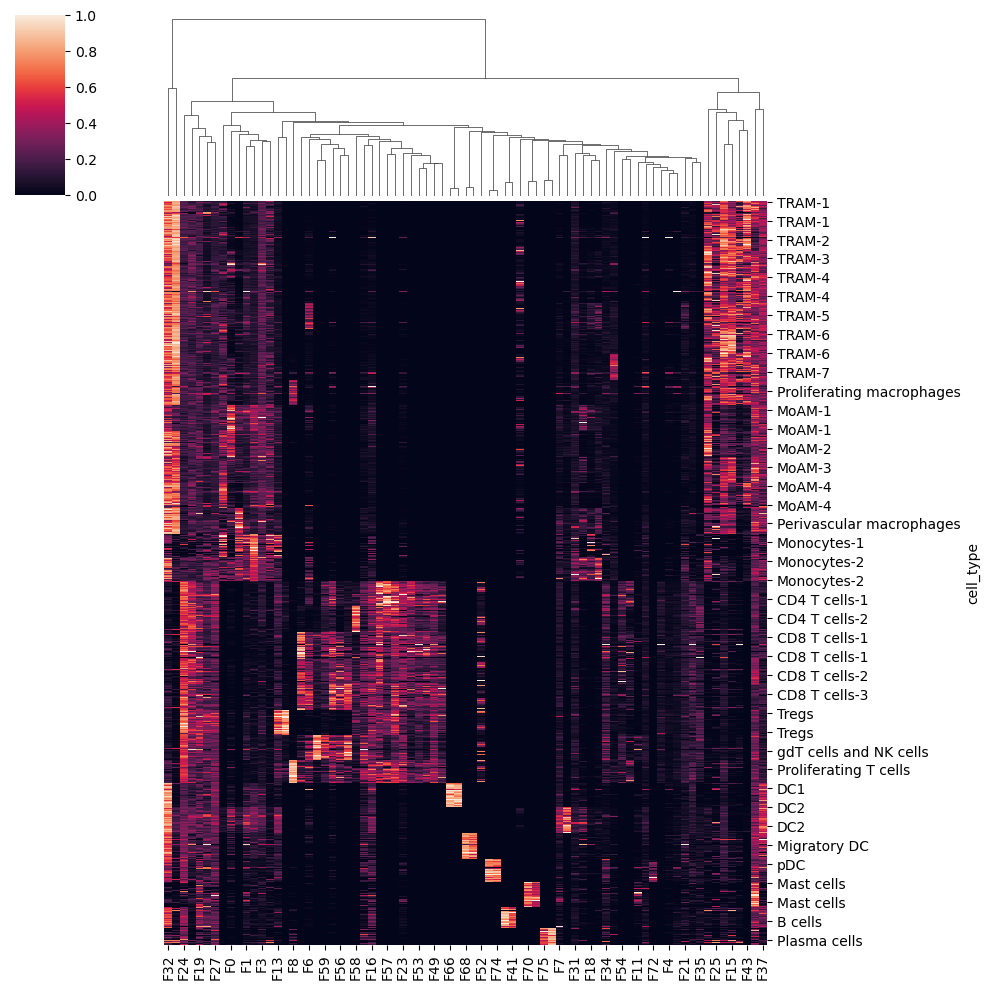

In [23]:
clmap = sns.clustermap(all_scores_sub, row_cluster = False, col_cluster = True)
col_inds = clmap.dendrogram_col.reordered_ind
sorted_scores = all_scores_sub.iloc[:, col_inds[::-1]]

In [24]:
sorted_scores.columns = pd.Index([''.join(x.split('_')[0:2]) for x in sorted_scores.columns])

In [25]:
# Shorten names when space is needed
sorted_scores.index = sorted_scores.index.str.replace('Proliferating macrophages', 'Prolif. MP')
sorted_scores.index = sorted_scores.index.str.replace('Perivascular macrophages', 'Periv. MP')
sorted_scores.index = sorted_scores.index.str.replace('Proliferating T cells', 'Prolif. T')
sorted_scores.index = sorted_scores.index.str.replace('gdT cells and NK cells', 'gdT, NK')
sorted_scores.index = sorted_scores.index.str.replace('Migratory DC', 'Migr. DC')
sorted_scores.index = sorted_scores.index.str.replace('Mast cells', 'Mast')
sorted_scores.index = sorted_scores.index.str.replace('Plasma cells', 'Plas.')
sorted_scores.index = sorted_scores.index.str.replace('Monocytes', 'Mono')
sorted_scores.index = sorted_scores.index.str.replace('T cells', 'T')

In [26]:
fig = plt.figure(figsize = (24, 12))
ax = fig.add_subplot()
sns.heatmap(sorted_scores.T, cbar_kws = {"shrink": 0.3, "pad": 0.015}, yticklabels = 1, linecolor = 'black')

ax.set_xlabel('')
ax.set_xticklabels([''] * len(ax.get_xticklabels()))
ax.tick_params(axis = 'x', which = 'both', bottom = False)
ax.tick_params(axis = 'y', labelsize = 10)

cell_names = sorted_scores.index.unique().tolist()
palette = sns.color_palette("muted")
colors = []
for i in range(int(np.ceil(len(cell_names) / len(palette)))):
    colors += palette

lw = 1.2
sc = 0
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1] - lw))
offset = [0, 1, 0, 0, 0, 0, 0, -1.7, -0.5, -0.5, -0.5, -0.5, -2.2, 2, 2, -0.4, -0.4, -0.4, -0.4, -0.4, 3.3, 0.1,
          2.2, 6, 5.5, -1, 6.3, 4.2, 4.3, 10.5]
for i in range(len(cell_names)):
    nc = np.sum(sorted_scores.index == cell_names[i])
    ax.add_patch(patches.Rectangle((sc, -lw), nc, lw, edgecolor = 'k', facecolor = colors[i]))
    ax.text(sc + nc - 27 + offset[i], -0.3, cell_names[i], size = 10)
    sc += nc

plt.tight_layout()
plt.savefig(f"{data_dir}/figures/fig_s3/fig_s3_e.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Correlation of factors with CT data

In [27]:
ct_data = pd.read_csv(f"{data_dir}/deidentified_data/deidentified_ct_scan_1_data.csv", index_col = 0)
ct_features = ['Normal', 'Fibrotic', 'Inflammatory', 'Nodularity']

In [28]:
rpra_scores = subject_scores.loc[subject_scores.Status == "RPRA"].reset_index(drop = True)

In [29]:
def get_scores(cell_type):
    # Subset to cell type
    scores = rpra_scores.loc[rpra_scores.cell_type == cell_type].copy()
    scores = scores.set_index("Study_ID")
    # Add CT data
    scores = pd.concat([scores, ct_data.loc[scores.index]], axis = 1)
    # Filter subjects
    total_cells = np.sum(adata.obs.cell_type == cell_type)
    cutoff = math.floor(CUTOFF * total_cells)
    scores = scores[scores.n_cell > max(MIN_CELLS, cutoff)]
    # Remove unused factors
    scores = scores.loc[:, scores.sum(axis = 0) != 0]
    return scores

In [ ]:
df_all = pd.DataFrame(columns = ['cell_type', 'ct_feature', 'Pathway', 'corr', 'pval', 'padj'])
for cell_type in cell_types:
    df = pd.DataFrame(columns = ['cell_type', 'ct_feature', 'Pathway', 'corr', 'pval'])
    scores_ct = get_scores(cell_type)
    
    # Require at least ten subjects
    if scores_ct.shape[0] < 10:
        print(f"Skipping {cell_type}")
        continue
    else:
        print(f"Testing {cell_type}")
    
    factors = scores_ct.columns[4:-5].to_list()
    for ct in ct_features:
        for pw in factors:
            test = scipy.stats.permutation_test(
                (scores_ct[ct],),
                lambda x: scipy.stats.spearmanr(x, scores_ct[pw]).statistic,
                permutation_type = 'pairings',
                n_resamples = 1e5
            )
            res = [cell_type, ct, pw, test.statistic, test.pvalue]
            df = pd.concat([df, pd.DataFrame([res], columns = df.columns)], ignore_index = True)
    _, df['padj'] = fdrcorrection(df.pval, alpha = 0.05, method = 'p')
    df_all = pd.concat([df_all, df])

In [ ]:
df_all_filt = df_all.loc[df_all.padj <= 0.05].sort_values("padj").reset_index(drop = True)
df_all_filt

In [ ]:
df_all_filt = df_all_filt.sort_values("cell_type").reset_index(drop = True)

In [ ]:
# Correlation plots
n = len(df_all_filt)
fig, axs = plt.subplots(1, n, figsize = (24, 4))
for ix in range(n):
    cell_type = df_all_filt['cell_type'][ix]
    ct = df_all_filt['ct_feature'][ix]
    pw = df_all_filt['Pathway'][ix]
    cr = df_all_filt['corr'][ix]
    q = df_all_filt['padj'][ix]
    scores_ct = get_scores(cell_type)

    axs[ix].scatter(scores_ct[ct], scores_ct[pw], color = 'k')
    axs[ix].set_title(cell_type, fontsize = 13)
    axs[ix].set_xlabel(ct, fontsize = 13)
    axs[ix].set_ylabel(pw, fontsize = 13)
    axs[ix].ticklabel_format(style = 'sci', scilimits = [-2, 6])

    cx = 0.03 if cr > 0 else 0.73
    axs[ix].text(cx, 0.94, f'$\\rho={cr:.3f}$', transform = axs[ix].transAxes, fontsize = 10)
    axs[ix].text(cx, 0.88, f'$q={q:.3f}$', transform = axs[ix].transAxes, fontsize = 10)
plt.tight_layout()
plt.savefig(f"{data_dir}/figures/fig_s4/fig_s4_e.pdf", bbox_inches = 'tight', transparent = True)
plt.close()